<a href="https://colab.research.google.com/github/ovbystrova/dpl/blob/master/notebooks/Language_model_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tokenizers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

from tokenizers import SentencePieceBPETokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
BATCH_SIZE = 64
MAX_SEQ_LENGTH = 35

In [4]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

--2020-05-03 12:27:11--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  8.06MB/s    in 0.5s    

2020-05-03 12:27:12 (8.06 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


In [0]:
def open_file(name):
    with open(name, 'r') as file:
        text = file.read()
    return text

def save_file(text, name):
    with open('/content/{}.txt'.format(name), 'w') as file:
        file.write(text)

def clean_data(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&[a-z]{0,7};', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\\\\x\d{1,4}', '', text)
    text = re.sub(r'=\s.{3,15}=\s', '', text)
    text = re.sub(r'\s@', ' ', text)
    text = re.sub(r'@\s', ' ', text)
    return text

def special_tokens(text):
    """
    Adds <eos> token if eos symbol occures.
    """
    eos = [' .', ' !', ' ?', ' ? !', ' \'n']
    eos_token = '<eos> <start>'
    for element in eos:
        text = text.replace(element, ' ' + eos_token + ' ')
    text = re.sub(r'<start>\s{2,10}<eos>', ' ', text)
    while '  ' in text:
        text = re.sub(r'\s{2,10}', ' ', text)
    text = '<start> ' + text
    return text

In [0]:
wiki_train = open_file('/content/wikitext-2/wiki.train.tokens')
wiki_train = clean_data(wiki_train)
wiki_train = special_tokens(wiki_train)
save_file(wiki_train, 'wiki_train')

wiki_valid = open_file('/content/wikitext-2/wiki.valid.tokens')
wiki_valid = clean_data(wiki_valid)
wiki_valid = special_tokens(wiki_valid)
save_file(wiki_train, 'wiki_valid')

In [8]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(['/content/wiki_train.txt', '/content/wiki_valid.txt'], special_tokens=['<eos>', '<unk>', '<start>'], vocab_size=30000)
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens

In [10]:
TEXT = data.Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize,lower=True, pad_first=True)
train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 9.05MB/s]


extracting


.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                           
100%|█████████▉| 399674/400000 [00:34<00:00, 11296.71it/s]

Vocab size: 22825


['<unk>', '<pad>', '▁', '▁the', '<eos>', '<start>', '▁,', '▁of', '▁and', '▁in']

In [11]:
train_iterator, valid_iterator, test_iterator = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=40,
    device=device,
    repeat=False)

b = next(iter(train_iterator)); vars(b).keys()

100%|█████████▉| 399674/400000 [00:50<00:00, 11296.71it/s]

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, 'text') else batch # because later we pass Tensor here
        
        x = self.embedding(x)           
        x, _ = self.rnn(x)
        x = self.fc(x)

        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0
    losses = []

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss, losses

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    losses = []

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches, losses

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    model = model.to(device)
    criterion = criterion.to(device)
    
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl = _test_epoch(model, valid_iterator, criterion)
        
        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, train_losses, valid_losses

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=200,
                hidden_size=128,
               )

model.embedding.weight.data.copy_(TEXT.vocab.vectors);

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

In [17]:
history, train_losses, valid_losses = nn_train(model, train_iterator, valid_iterator, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



validation loss 1.44721



validation loss 0.51300



validation loss 0.28079



validation loss 0.21421



validation loss 0.19187



validation loss 0.18270



validation loss 0.17898



validation loss 0.17815



validation loss 0.17882



validation loss 0.18033
Early stopping! best epoch: 7 val 0.17815


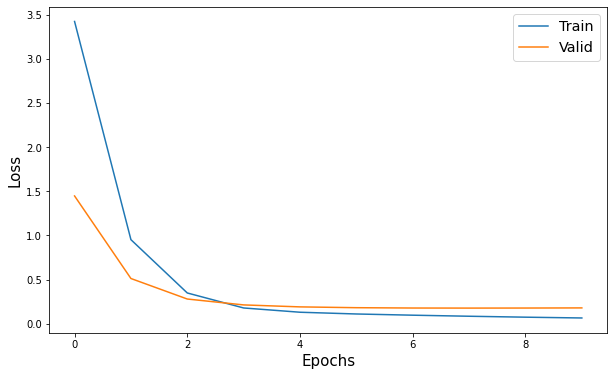

In [18]:
# Loss by epoch
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

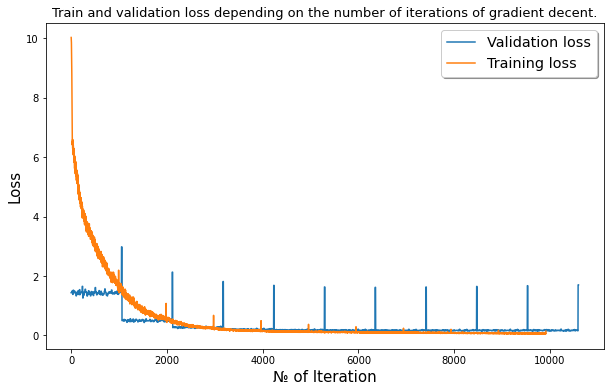

In [19]:
# Loss by iteration
new_val = [el for el in valid_losses for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(new_val, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation loss depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()